# regression_part_1_linear_regression

## Data import and test

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold


#Martim added imports from week 8
from sklearn import model_selection
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge


In [2]:
name_data_file="heart_failure_clinical_records_dataset"

data = pd.read_csv(f"../../raw_data/{name_data_file}.csv", na_values=["?"])

In [3]:
data

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


## Data Processing

In [4]:
# continuous and binary columns
continuous_cols = [
    "age",
    "creatinine_phosphokinase", 
    "ejection_fraction",
    "platelets",
    "serum_creatinine",
    "serum_sodium",
]
binary_cols = ["anaemia", "diabetes", "high_blood_pressure", "sex", "smoking", "DEATH_EVENT"]

from what Godinho and Ribau discussed we don´t need a one out of k encoding

In [5]:
# Predictors and target
y = data["time"]
X = data.drop(columns=["time"])  # remove target

## Log transform of CDK column

In [160]:
# Log-transform: creatinine_phosphokinase column
X["creatinine_phosphokinase"] = np.log1p(X["creatinine_phosphokinase"])

#### check data

In [6]:
X

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,0


## Regularization parameter λ and Generalization Error

### with DEATH_EVENT

#### λ range

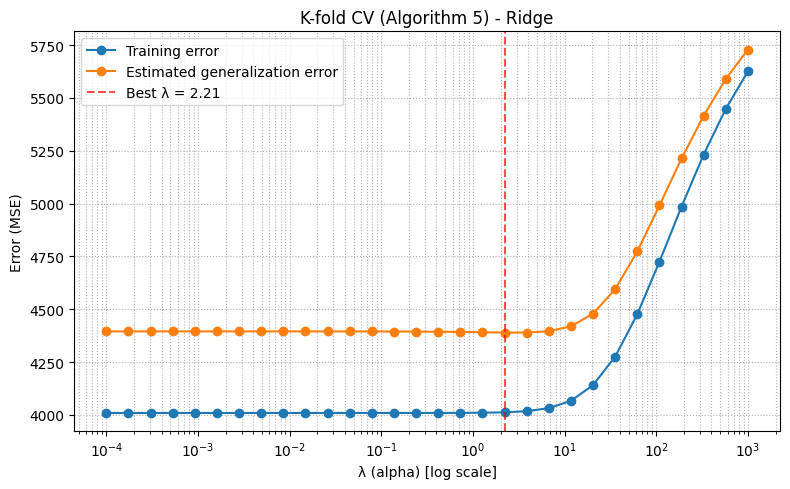

In [7]:
# --- 3. Cross-validation setup (Algorithm 5) ---
K = 10
kf = KFold(n_splits=K, shuffle=True, random_state=42)
lambdas = np.logspace(-4, 3, 30)  # same search grid as in class

# Containers
train_err_mean, train_err_std = [], []
gen_err_est, test_err_std = [], []

# --- 4. Helper function for z-score standardization ---
def standardize_continuous(X_train_df, X_test_df, cont_cols):
    """Standardize continuous variables using train fold statistics."""
    mu = X_train_df[cont_cols].mean(axis=0)
    sigma = X_train_df[cont_cols].std(axis=0, ddof=0).replace(0, 1.0)

    X_train_std = X_train_df.copy()
    X_test_std = X_test_df.copy()

    for X_ in [X_train_std, X_test_std]:
        X_[cont_cols] = X_[cont_cols].astype("float64")
        X_.loc[:, cont_cols] = (X_[cont_cols] - mu) / sigma
    return X_train_std, X_test_std

# --- 5. K-fold CV across λ values ---
N_total = len(X)
for lam in lambdas:
    fold_train_errs, fold_test_errs, fold_weights = [], [], []

    for train_idx, test_idx in kf.split(X, y):
        X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        X_train, X_test = standardize_continuous(X_train, X_test, continuous_cols)

        model = Ridge(alpha=lam, random_state=42)
        model.fit(X_train, y_train)

        fold_train_errs.append(mean_squared_error(y_train, model.predict(X_train)))
        fold_test_errs.append(mean_squared_error(y_test, model.predict(X_test)))
        fold_weights.append(len(test_idx) / N_total)

    # Aggregate fold errors
    train_err_mean.append(np.mean(fold_train_errs))
    train_err_std.append(np.std(fold_train_errs, ddof=1))
    gen_err_est.append(np.sum(np.array(fold_weights) * np.array(fold_test_errs)))
    test_err_std.append(np.std(fold_test_errs, ddof=1))

# --- 6. Compile results ---
cv_table = pd.DataFrame({
    "lambda": lambdas,
    "train_mse_mean": train_err_mean,
    "train_mse_std": train_err_std,
    "gen_mse_est": gen_err_est,
    "test_mse_std": test_err_std,
})

best_idx = np.argmin(cv_table["gen_mse_est"])
best_lambda = cv_table.loc[best_idx, "lambda"]
best_gen_mse = cv_table.loc[best_idx, "gen_mse_est"]

# --- 7. Plot CV results ---
plt.figure(figsize=(8, 5))
plt.semilogx(lambdas, cv_table["train_mse_mean"], "o-", label="Training error")
plt.semilogx(lambdas, cv_table["gen_mse_est"], "o-", label="Estimated generalization error")
plt.axvline(best_lambda, linestyle="--", color="r", alpha=0.7, label=f"Best λ = {best_lambda:.3g}")
plt.xlabel("λ (alpha) [log scale]")
plt.ylabel("Error (MSE)")
plt.title("K-fold CV (Algorithm 5) - Ridge")
plt.legend()
plt.grid(True, which="both", ls=":")
plt.tight_layout()
plt.show()

===== 10-fold CV (Ridge) — continuous-only scaling =====
     lambda  train_mse_mean  train_mse_std  gen_mse_est  test_mse_std
   0.000100     4009.090329     108.383838  4395.046350   1075.468652
   0.000174     4009.090329     108.383838  4395.046045   1075.468776
   0.000304     4009.090329     108.383838  4395.045513   1075.468993
   0.000530     4009.090329     108.383838  4395.044587   1075.469371
   0.000924     4009.090330     108.383838  4395.042971   1075.470029
   0.001610     4009.090331     108.383838  4395.040156   1075.471178
   0.002807     4009.090334     108.383838  4395.035249   1075.473180
   0.004894     4009.090345     108.383838  4395.026701   1075.476672
   0.008532     4009.090377     108.383838  4395.011815   1075.482760
   0.014874     4009.090476     108.383838  4394.985917   1075.493381
   0.025929     4009.090775     108.383840  4394.940927   1075.511916
   0.045204     4009.091685     108.383845  4394.862976   1075.544286
   0.078805     4009.094443     1

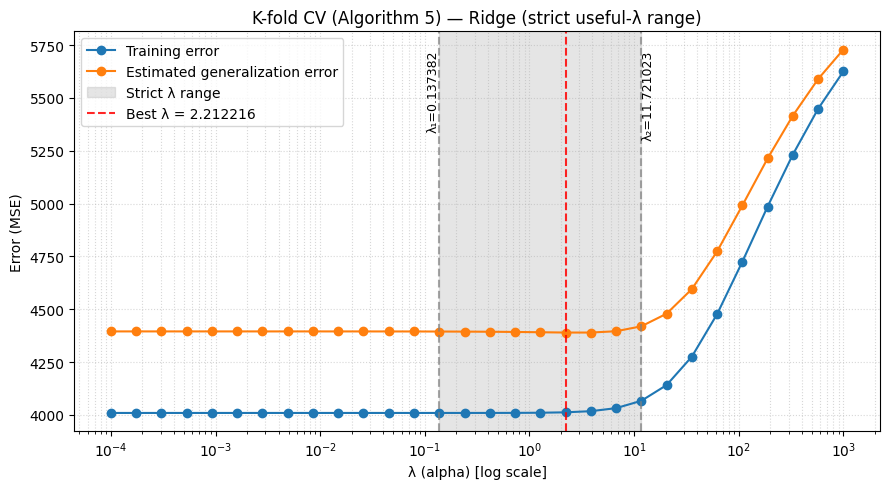


===== Coefficients (best λ model, standardized scale) =====
                 feature  coef_std_scale
             DEATH_EVENT      -82.977293
     high_blood_pressure      -23.659279
                 anaemia      -16.005925
       ejection_fraction       -7.037114
                 smoking       -5.687960
                     sex       -5.371205
                     age       -5.248918
                diabetes        2.338897
            serum_sodium        1.355628
creatinine_phosphokinase       -1.148913
        serum_creatinine        1.132385
               platelets       -0.993039


In [8]:
# --- Useful λ range: strict relative + tightened 1-SE ---
gen = cv_table["gen_mse_est"].values
sd  = cv_table["test_mse_std"].values
lams = cv_table["lambda"].values.astype(float)
K_eff = K

# Índice e valor do mínimo
idx_min = int(np.argmin(gen))
best_lambda = float(lams[idx_min])
best_gen_mse = float(gen[idx_min])

# ================================
# 🔹 Parâmetros otimizados (sem cap)
# ================================
rel_tol   = 0.01    # 1% acima do mínimo
se_factor = 0.25    # 0.25-SE (mais restrito)
max_span  = 5       # no máximo 5 pontos para cada lado

# ================================
# 🔹 Threshold = mais apertado entre critério relativo e SE
# ================================
se_min = sd[idx_min] / np.sqrt(K_eff)
thr_rel = best_gen_mse * (1.0 + rel_tol)
thr_se  = best_gen_mse + se_factor * se_min
threshold = min(thr_rel, thr_se)

# Índices com erro dentro do threshold
ok = np.where(gen <= threshold)[0]

# Encontrar bloco contíguo que contém o mínimo
left_idx = idx_min
while (left_idx - 1) in ok:
    left_idx -= 1
right_idx = idx_min
while (right_idx + 1) in ok:
    right_idx += 1

# ================================
# 🔹 Limitar intervalo para evitar exageros (apenas pelo nº de pontos)
# ================================
left_idx  = max(left_idx,  idx_min - max_span)
right_idx = min(right_idx, idx_min + max_span)

# Extrair os valores de λ correspondentes
lambda_left  = float(lams[left_idx])
lambda_right = float(lams[right_idx])
useful_range = (lambda_left, lambda_right)

print("===== 10-fold CV (Ridge) — continuous-only scaling =====")
print(cv_table.to_string(index=False, float_format=lambda v: f"{v:.6f}"))
print(f"\nBest λ (alpha): {best_lambda:.6g}")
print(f"Estimated generalization error (MSE): {best_gen_mse:.6f}")
print(f"Useful λ range (strict): {useful_range[0]:.6f} → {useful_range[1]:.6f} "
      f"(rel_tol={rel_tol*100:.1f}%, se_factor={se_factor})")

# --- Plot ---
plt.figure(figsize=(9,5))
plt.semilogx(lams, cv_table["train_mse_mean"], marker="o", label="Training error")
plt.semilogx(lams, cv_table["gen_mse_est"],  marker="o", label="Estimated generalization error")

# Banda + limites
plt.axvspan(useful_range[0], useful_range[1], color="gray", alpha=0.2, label="Strict λ range")
plt.axvline(best_lambda, linestyle="--", color="red", alpha=0.85, label=f"Best λ = {best_lambda:.6f}")
plt.axvline(useful_range[0], linestyle="--", color="gray", alpha=0.7)
plt.axvline(useful_range[1], linestyle="--", color="gray", alpha=0.7)

# Add text labels with REAL λ values (no rounding)
y_top = plt.ylim()[1]
plt.text(useful_range[0], y_top*0.985, f"λ₁={useful_range[0]:.6f}", rotation=90,
         va='top', ha='right', fontsize=9, color='black')
plt.text(useful_range[1], y_top*0.985, f"λ₂={useful_range[1]:.6f}", rotation=90,
         va='top', ha='left', fontsize=9, color='black')

plt.xlabel("λ (alpha) [log scale]")
plt.ylabel("Error (MSE)")
plt.title("K-fold CV (Algorithm 5) — Ridge (strict useful-λ range)")
plt.legend()
plt.grid(True, which="both", ls=":", alpha=0.5)
plt.tight_layout()
plt.show()

# Final model fit on the FULL dataset (for point 3 of part 1-A) 
# Standardize continuous columns using FULL-data stats, then refit with best λ
mu_full = X[continuous_cols].mean(axis=0)
sigma_full = X[continuous_cols].std(axis=0, ddof=0).replace(0, 1.0)

# Work only on X_std_full and cast continuous cols to float BEFORE computing stats
X_std_full = X.copy()
X_std_full[continuous_cols] = X_std_full[continuous_cols].astype("float64")

# Compute scaling stats from FULL data (on float cols)
mu_full = X_std_full[continuous_cols].mean(axis=0)
sigma_full = X_std_full[continuous_cols].std(axis=0, ddof=0).replace(0, 1.0)

# Apply z-score using FULL-data stats (note: use X_std_full on both sides)
X_std_full.loc[:, continuous_cols] = (X_std_full[continuous_cols] - mu_full) / sigma_full

# Fit final ridge with best λ
best_model = Ridge(alpha=best_lambda, random_state=42)
best_model.fit(X_std_full, y)

coef_table = pd.DataFrame({
    "feature": X_std_full.columns,
    "coef_std_scale": best_model.coef_
}).sort_values("coef_std_scale", key=np.abs, ascending=False)

print("\n===== Coefficients (best λ model, standardized scale) =====")
print(coef_table.to_string(index=False, float_format=lambda v: f"{v:.6f}"))

#### How the model computes y for a given x:

In [9]:
# --- Coefficient table with interpretation units ---
coef_df = pd.DataFrame({
    "feature": X_std_full.columns,
    "coef": best_model.coef_
})
coef_df["type"] = np.where(coef_df["feature"].isin(continuous_cols), "continuous", "binary")

# For continuous: a +1 SD change -> +coef days; for binary: 0→1 -> +coef days
coef_df["effect_unit"] = np.where(
    coef_df["type"] == "continuous",
    "per +1 SD (z-scored)",
    "0→1 change"
)

# Sort by absolute effect size
coef_df = coef_df.sort_values("coef", key=np.abs, ascending=False).reset_index(drop=True)

print("\n=== Coefficients and interpretation units ===")
print(coef_df.to_string(index=False, float_format=lambda v: f"{v:.6f}"))

# Separate clearly positive and negative drivers
top_positive = coef_df[coef_df["coef"] > 0].sort_values("coef", ascending=False).head()
top_negative = coef_df[coef_df["coef"] < 0].sort_values("coef", ascending=True).head()

print("\nTop positive drivers (increase y):")
print(top_positive.to_string(index=False))

print("\nTop negative drivers (decrease y):")
print(top_negative.to_string(index=False))


=== Coefficients and interpretation units ===
                 feature       coef       type          effect_unit
             DEATH_EVENT -82.977293     binary           0→1 change
     high_blood_pressure -23.659279     binary           0→1 change
                 anaemia -16.005925     binary           0→1 change
       ejection_fraction  -7.037114 continuous per +1 SD (z-scored)
                 smoking  -5.687960     binary           0→1 change
                     sex  -5.371205     binary           0→1 change
                     age  -5.248918 continuous per +1 SD (z-scored)
                diabetes   2.338897     binary           0→1 change
            serum_sodium   1.355628 continuous per +1 SD (z-scored)
creatinine_phosphokinase  -1.148913 continuous per +1 SD (z-scored)
        serum_creatinine   1.132385 continuous per +1 SD (z-scored)
               platelets  -0.993039 continuous per +1 SD (z-scored)

Top positive drivers (increase y):
         feature     coef       t

#### Example prediction

In [10]:
# --- Pick an example patient ---
example_idx = 0
example_raw = X.iloc[example_idx]
true_y = data.loc[example_idx, "time"]

def predict_from_raw_row(raw_row: pd.Series) -> float:
    """
    Predict the expected follow-up time (ŷ) for a new patient (raw_row).
    The transformations mirror those used during training.
    """
    x = raw_row.copy()

    # 1) Apply the same feature transformation as in training
    x["creatinine_phosphokinase"] = np.log1p(x["creatinine_phosphokinase"])

    # 2) Build DataFrame with the same column order as the training set
    x_df = pd.DataFrame([x], columns=X_std_full.columns)

    # 3) Ensure continuous columns are float
    x_df[continuous_cols] = x_df[continuous_cols].astype("float64")

    # 4) Standardize continuous columns using full-dataset stats
    x_df.loc[:, continuous_cols] = (x_df[continuous_cols] - mu_full) / sigma_full

    # 5) Predict using the trained ridge model
    y_hat = best_model.predict(x_df)[0]
    return float(y_hat)

# --- Predict using the same function ---
y_hat_example = predict_from_raw_row(example_raw)

# --- Print results side by side ---
print(f"\n=== Example prediction (patient index {example_idx}) ===")
print(f"True follow-up time (y):      {true_y:.2f} days")
print(f"Predicted follow-up (ŷ):      {y_hat_example:.2f} days")
print(f"Prediction error:             {y_hat_example - true_y:+.2f} days\n")

# --- Algebraic expression of the Ridge model ---
print("=== Algebraic form of the final Ridge Regression model ===\n")

intercept = best_model.intercept_
coefs = best_model.coef_

# Express model as: ŷ = intercept + Σ w_i * x_i
expression = "ŷ = {:.3f}".format(intercept)
for feat, coef in zip(X_std_full.columns, coefs):
    sign = "+" if coef >= 0 else "-"
    expression += f" {sign} {abs(coef):.3f}·{feat}"
print(expression + "\n")

# --- Contribution breakdown for this patient ---
# Build transformed version of the row (standardized like training)
x = example_raw.copy()
x["creatinine_phosphokinase"] = np.log1p(x["creatinine_phosphokinase"])
x_df = pd.DataFrame([x], columns=X_std_full.columns)
x_df[continuous_cols] = x_df[continuous_cols].astype("float64")
x_df.loc[:, continuous_cols] = (x_df[continuous_cols] - mu_full) / sigma_full

# Compute individual contributions
contrib = x_df.values[0] * coefs
contrib_df = pd.DataFrame({
    "feature": X_std_full.columns,
    "x_value": x_df.values[0],
    "coef": coefs,
    "contribution (coef*x)": contrib
})
contrib_df["abs_contribution"] = contrib_df["contribution (coef*x)"].abs()
contrib_df = contrib_df.sort_values("abs_contribution", ascending=False)

print("=== Feature contributions to prediction ===")
print(contrib_df[["feature", "x_value", "coef", "contribution (coef*x)"]]
      .to_string(index=False, float_format=lambda v: f"{v:.3f}"))


=== Example prediction (patient index 0) ===
True follow-up time (y):      4.00 days
Predicted follow-up (ŷ):      68.13 days
Prediction error:             +64.13 days

=== Algebraic form of the final Ridge Regression model ===

ŷ = 176.450 - 5.249·age - 16.006·anaemia - 1.149·creatinine_phosphokinase + 2.339·diabetes - 7.037·ejection_fraction - 23.659·high_blood_pressure - 0.993·platelets + 1.132·serum_creatinine + 1.356·serum_sodium - 5.371·sex - 5.688·smoking - 82.977·DEATH_EVENT

=== Feature contributions to prediction ===
                 feature  x_value    coef  contribution (coef*x)
             DEATH_EVENT    1.000 -82.977                -82.977
     high_blood_pressure    1.000 -23.659                -23.659
       ejection_fraction   -1.531  -7.037                 10.771
                     age    1.193  -5.249                 -6.262
                     sex    1.000  -5.371                 -5.371
            serum_sodium   -1.504   1.356                 -2.039
creatinine_

In [11]:
data["time"].mean()

np.float64(130.2608695652174)

### without DEATH_EVENT

#### X feature transformation

In [12]:
# Remove variable in study 
X = X.drop(columns=["DEATH_EVENT"])

#### λ range

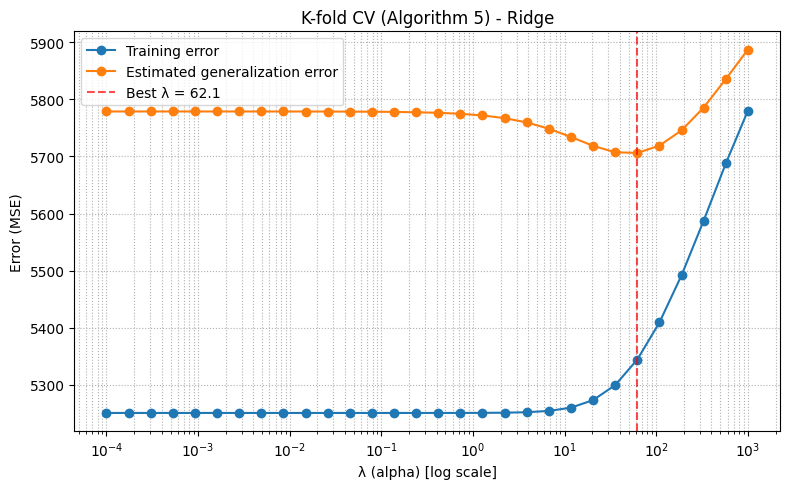

In [13]:
# --- 3. Cross-validation setup (Algorithm 5) ---
K = 10
kf = KFold(n_splits=K, shuffle=True, random_state=42)
lambdas = np.logspace(-4, 3, 30)  # same search grid as in class

# Containers
train_err_mean, train_err_std = [], []
gen_err_est, test_err_std = [], []

# --- 4. Helper function for z-score standardization ---
def standardize_continuous(X_train_df, X_test_df, cont_cols):
    """Standardize continuous variables using train fold statistics."""
    mu = X_train_df[cont_cols].mean(axis=0)
    sigma = X_train_df[cont_cols].std(axis=0, ddof=0).replace(0, 1.0)

    X_train_std = X_train_df.copy()
    X_test_std = X_test_df.copy()

    for X_ in [X_train_std, X_test_std]:
        X_[cont_cols] = X_[cont_cols].astype("float64")
        X_.loc[:, cont_cols] = (X_[cont_cols] - mu) / sigma
    return X_train_std, X_test_std

# --- 5. K-fold CV across λ values ---
N_total = len(X)
for lam in lambdas:
    fold_train_errs, fold_test_errs, fold_weights = [], [], []

    for train_idx, test_idx in kf.split(X, y):
        X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        X_train, X_test = standardize_continuous(X_train, X_test, continuous_cols)

        model = Ridge(alpha=lam, random_state=42)
        model.fit(X_train, y_train)

        fold_train_errs.append(mean_squared_error(y_train, model.predict(X_train)))
        fold_test_errs.append(mean_squared_error(y_test, model.predict(X_test)))
        fold_weights.append(len(test_idx) / N_total)

    # Aggregate fold errors
    train_err_mean.append(np.mean(fold_train_errs))
    train_err_std.append(np.std(fold_train_errs, ddof=1))
    gen_err_est.append(np.sum(np.array(fold_weights) * np.array(fold_test_errs)))
    test_err_std.append(np.std(fold_test_errs, ddof=1))

# --- 6. Compile results ---
cv_table = pd.DataFrame({
    "lambda": lambdas,
    "train_mse_mean": train_err_mean,
    "train_mse_std": train_err_std,
    "gen_mse_est": gen_err_est,
    "test_mse_std": test_err_std,
})

best_idx = np.argmin(cv_table["gen_mse_est"])
best_lambda = cv_table.loc[best_idx, "lambda"]
best_gen_mse = cv_table.loc[best_idx, "gen_mse_est"]

# --- 7. Plot CV results ---
plt.figure(figsize=(8, 5))
plt.semilogx(lambdas, cv_table["train_mse_mean"], "o-", label="Training error")
plt.semilogx(lambdas, cv_table["gen_mse_est"], "o-", label="Estimated generalization error")
plt.axvline(best_lambda, linestyle="--", color="r", alpha=0.7, label=f"Best λ = {best_lambda:.3g}")
plt.xlabel("λ (alpha) [log scale]")
plt.ylabel("Error (MSE)")
plt.title("K-fold CV (Algorithm 5) - Ridge")
plt.legend()
plt.grid(True, which="both", ls=":")
plt.tight_layout()
plt.show()

===== 10-fold CV (Ridge) — continuous-only scaling =====
     lambda  train_mse_mean  train_mse_std  gen_mse_est  test_mse_std
   0.000100     5250.541977     162.341563  5778.805490   1584.638018
   0.000174     5250.541977     162.341563  5778.805062   1584.637575
   0.000304     5250.541977     162.341563  5778.804316   1584.636804
   0.000530     5250.541977     162.341563  5778.803015   1584.635460
   0.000924     5250.541977     162.341563  5778.800748   1584.633117
   0.001610     5250.541977     162.341563  5778.796796   1584.629031
   0.002807     5250.541978     162.341563  5778.789906   1584.621910
   0.004894     5250.541979     162.341563  5778.777897   1584.609495
   0.008532     5250.541984     162.341563  5778.756965   1584.587853
   0.014874     5250.541998     162.341562  5778.720489   1584.550130
   0.025929     5250.542042     162.341560  5778.656942   1584.484381
   0.045204     5250.542176     162.341555  5778.546291   1584.369808
   0.078805     5250.542580     1

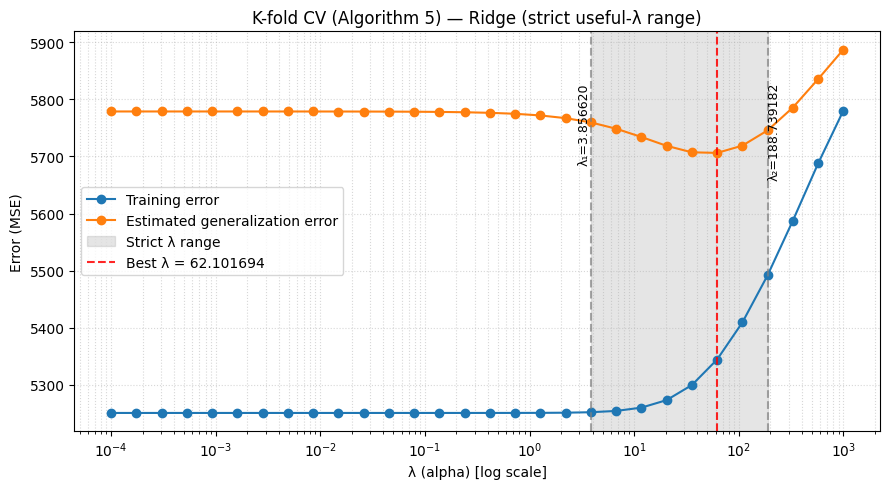


===== Coefficients (best λ model, standardized scale) =====
                 feature  coef_std_scale
     high_blood_pressure      -15.743423
                     age      -12.574663
                 anaemia      -11.125350
        serum_creatinine       -7.078987
            serum_sodium        4.264946
creatinine_phosphokinase       -2.940776
       ejection_fraction        2.740233
                 smoking       -2.639907
                diabetes        1.135909
               platelets       -0.354356
                     sex       -0.321349


In [14]:
# --- Useful λ range: strict relative + tightened 1-SE ---
gen = cv_table["gen_mse_est"].values
sd  = cv_table["test_mse_std"].values
lams = cv_table["lambda"].values.astype(float)
K_eff = K

# Índice e valor do mínimo
idx_min = int(np.argmin(gen))
best_lambda = float(lams[idx_min])
best_gen_mse = float(gen[idx_min])

# ================================
# 🔹 Parâmetros otimizados (sem cap)
# ================================
rel_tol   = 0.01    # 1% acima do mínimo
se_factor = 0.25    # 0.25-SE (mais restrito)
max_span  = 5       # no máximo 5 pontos para cada lado

# ================================
# 🔹 Threshold = mais apertado entre critério relativo e SE
# ================================
se_min = sd[idx_min] / np.sqrt(K_eff)
thr_rel = best_gen_mse * (1.0 + rel_tol)
thr_se  = best_gen_mse + se_factor * se_min
threshold = min(thr_rel, thr_se)

# Índices com erro dentro do threshold
ok = np.where(gen <= threshold)[0]

# Encontrar bloco contíguo que contém o mínimo
left_idx = idx_min
while (left_idx - 1) in ok:
    left_idx -= 1
right_idx = idx_min
while (right_idx + 1) in ok:
    right_idx += 1

# ================================
# 🔹 Limitar intervalo para evitar exageros (apenas pelo nº de pontos)
# ================================
left_idx  = max(left_idx,  idx_min - max_span)
right_idx = min(right_idx, idx_min + max_span)

# Extrair os valores de λ correspondentes
lambda_left  = float(lams[left_idx])
lambda_right = float(lams[right_idx])
useful_range = (lambda_left, lambda_right)

print("===== 10-fold CV (Ridge) — continuous-only scaling =====")
print(cv_table.to_string(index=False, float_format=lambda v: f"{v:.6f}"))
print(f"\nBest λ (alpha): {best_lambda:.6g}")
print(f"Estimated generalization error (MSE): {best_gen_mse:.6f}")
print(f"Useful λ range (strict): {useful_range[0]:.6f} → {useful_range[1]:.6f} "
      f"(rel_tol={rel_tol*100:.1f}%, se_factor={se_factor})")

# --- Plot ---
plt.figure(figsize=(9,5))
plt.semilogx(lams, cv_table["train_mse_mean"], marker="o", label="Training error")
plt.semilogx(lams, cv_table["gen_mse_est"],  marker="o", label="Estimated generalization error")

# Banda + limites
plt.axvspan(useful_range[0], useful_range[1], color="gray", alpha=0.2, label="Strict λ range")
plt.axvline(best_lambda, linestyle="--", color="red", alpha=0.85, label=f"Best λ = {best_lambda:.6f}")
plt.axvline(useful_range[0], linestyle="--", color="gray", alpha=0.7)
plt.axvline(useful_range[1], linestyle="--", color="gray", alpha=0.7)

# Add text labels with REAL λ values (no rounding)
y_top = plt.ylim()[1]
plt.text(useful_range[0], y_top*0.985, f"λ₁={useful_range[0]:.6f}", rotation=90,
         va='top', ha='right', fontsize=9, color='black')
plt.text(useful_range[1], y_top*0.985, f"λ₂={useful_range[1]:.6f}", rotation=90,
         va='top', ha='left', fontsize=9, color='black')

plt.xlabel("λ (alpha) [log scale]")
plt.ylabel("Error (MSE)")
plt.title("K-fold CV (Algorithm 5) — Ridge (strict useful-λ range)")
plt.legend()
plt.grid(True, which="both", ls=":", alpha=0.5)
plt.tight_layout()
plt.show()

# Final model fit on the FULL dataset (for point 3 of part 1-A) 
# Standardize continuous columns using FULL-data stats, then refit with best λ
mu_full = X[continuous_cols].mean(axis=0)
sigma_full = X[continuous_cols].std(axis=0, ddof=0).replace(0, 1.0)

# Work only on X_std_full and cast continuous cols to float BEFORE computing stats
X_std_full = X.copy()
X_std_full[continuous_cols] = X_std_full[continuous_cols].astype("float64")

# Compute scaling stats from FULL data (on float cols)
mu_full = X_std_full[continuous_cols].mean(axis=0)
sigma_full = X_std_full[continuous_cols].std(axis=0, ddof=0).replace(0, 1.0)

# Apply z-score using FULL-data stats (note: use X_std_full on both sides)
X_std_full.loc[:, continuous_cols] = (X_std_full[continuous_cols] - mu_full) / sigma_full

# Fit final ridge with best λ
best_model = Ridge(alpha=best_lambda, random_state=42)
best_model.fit(X_std_full, y)

coef_table = pd.DataFrame({
    "feature": X_std_full.columns,
    "coef_std_scale": best_model.coef_
}).sort_values("coef_std_scale", key=np.abs, ascending=False)

print("\n===== Coefficients (best λ model, standardized scale) =====")
print(coef_table.to_string(index=False, float_format=lambda v: f"{v:.6f}"))

#### How the model computes y for a given x:

In [15]:
# --- Coefficient table with interpretation units ---
coef_df = pd.DataFrame({
    "feature": X_std_full.columns,
    "coef": best_model.coef_
})
coef_df["type"] = np.where(coef_df["feature"].isin(continuous_cols), "continuous", "binary")

# For continuous: a +1 SD change -> +coef days; for binary: 0→1 -> +coef days
coef_df["effect_unit"] = np.where(
    coef_df["type"] == "continuous",
    "per +1 SD (z-scored)",
    "0→1 change"
)

# Sort by absolute effect size
coef_df = coef_df.sort_values("coef", key=np.abs, ascending=False).reset_index(drop=True)

print("\n=== Coefficients and interpretation units ===")
print(coef_df.to_string(index=False, float_format=lambda v: f"{v:.6f}"))

# Separate clearly positive and negative drivers
top_positive = coef_df[coef_df["coef"] > 0].sort_values("coef", ascending=False).head()
top_negative = coef_df[coef_df["coef"] < 0].sort_values("coef", ascending=True).head()

print("\nTop positive drivers (increase y):")
print(top_positive.to_string(index=False))

print("\nTop negative drivers (decrease y):")
print(top_negative.to_string(index=False))


=== Coefficients and interpretation units ===
                 feature       coef       type          effect_unit
     high_blood_pressure -15.743423     binary           0→1 change
                     age -12.574663 continuous per +1 SD (z-scored)
                 anaemia -11.125350     binary           0→1 change
        serum_creatinine  -7.078987 continuous per +1 SD (z-scored)
            serum_sodium   4.264946 continuous per +1 SD (z-scored)
creatinine_phosphokinase  -2.940776 continuous per +1 SD (z-scored)
       ejection_fraction   2.740233 continuous per +1 SD (z-scored)
                 smoking  -2.639907     binary           0→1 change
                diabetes   1.135909     binary           0→1 change
               platelets  -0.354356 continuous per +1 SD (z-scored)
                     sex  -0.321349     binary           0→1 change

Top positive drivers (increase y):
          feature     coef       type          effect_unit
     serum_sodium 4.264946 continuous per 

#### Example prediction

In [16]:
# --- Pick an example patient ---
example_idx = 0
example_raw = X.iloc[example_idx]
true_y = data.loc[example_idx, "time"]

def predict_from_raw_row(raw_row: pd.Series) -> float:
    """
    Predict the expected follow-up time (ŷ) for a new patient (raw_row).
    The transformations mirror those used during training.
    """
    x = raw_row.copy()

    # 1) Apply the same feature transformation as in training
    x["creatinine_phosphokinase"] = np.log1p(x["creatinine_phosphokinase"])

    # 2) Build DataFrame with the same column order as the training set
    x_df = pd.DataFrame([x], columns=X_std_full.columns)

    # 3) Ensure continuous columns are float
    x_df[continuous_cols] = x_df[continuous_cols].astype("float64")

    # 4) Standardize continuous columns using full-dataset stats
    x_df.loc[:, continuous_cols] = (x_df[continuous_cols] - mu_full) / sigma_full

    # 5) Predict using the trained ridge model
    y_hat = best_model.predict(x_df)[0]
    return float(y_hat)

# --- Predict using the same function ---
y_hat_example = predict_from_raw_row(example_raw)

# --- Print results side by side ---
print(f"\n=== Example prediction (patient index {example_idx}) ===")
print(f"True follow-up time (y):      {true_y:.2f} days")
print(f"Predicted follow-up (ŷ):      {y_hat_example:.2f} days")
print(f"Prediction error:             {y_hat_example - true_y:+.2f} days\n")

# --- Algebraic expression of the Ridge model ---
print("=== Algebraic form of the final Ridge Regression model ===\n")

intercept = best_model.intercept_
coefs = best_model.coef_

# Express model as: ŷ = intercept + Σ w_i * x_i
expression = "ŷ = {:.3f}".format(intercept)
for feat, coef in zip(X_std_full.columns, coefs):
    sign = "+" if coef >= 0 else "-"
    expression += f" {sign} {abs(coef):.3f}·{feat}"
print(expression + "\n")

# --- Contribution breakdown for this patient ---
# Build transformed version of the row (standardized like training)
x = example_raw.copy()
x["creatinine_phosphokinase"] = np.log1p(x["creatinine_phosphokinase"])
x_df = pd.DataFrame([x], columns=X_std_full.columns)
x_df[continuous_cols] = x_df[continuous_cols].astype("float64")
x_df.loc[:, continuous_cols] = (x_df[continuous_cols] - mu_full) / sigma_full

# Compute individual contributions
contrib = x_df.values[0] * coefs
contrib_df = pd.DataFrame({
    "feature": X_std_full.columns,
    "x_value": x_df.values[0],
    "coef": coefs,
    "contribution (coef*x)": contrib
})
contrib_df["abs_contribution"] = contrib_df["contribution (coef*x)"].abs()
contrib_df = contrib_df.sort_values("abs_contribution", ascending=False)

print("=== Feature contributions to prediction ===")
print(contrib_df[["feature", "x_value", "coef", "contribution (coef*x)"]]
      .to_string(index=False, float_format=lambda v: f"{v:.3f}"))


=== Example prediction (patient index 0) ===
True follow-up time (y):      4.00 days
Predicted follow-up (ŷ):      97.77 days
Prediction error:             +93.77 days

=== Algebraic form of the final Ridge Regression model ===

ŷ = 141.171 - 12.575·age - 11.125·anaemia - 2.941·creatinine_phosphokinase + 1.136·diabetes + 2.740·ejection_fraction - 15.743·high_blood_pressure - 0.354·platelets - 7.079·serum_creatinine + 4.265·serum_sodium - 0.321·sex - 2.640·smoking

=== Feature contributions to prediction ===
                 feature  x_value    coef  contribution (coef*x)
     high_blood_pressure    1.000 -15.743                -15.743
                     age    1.193 -12.575                -15.001
            serum_sodium   -1.504   4.265                 -6.415
       ejection_fraction   -1.531   2.740                 -4.194
        serum_creatinine    0.490  -7.079                 -3.469
creatinine_phosphokinase   -0.594  -2.941                  1.747
                     sex    1.0

## 4 setup comparation:

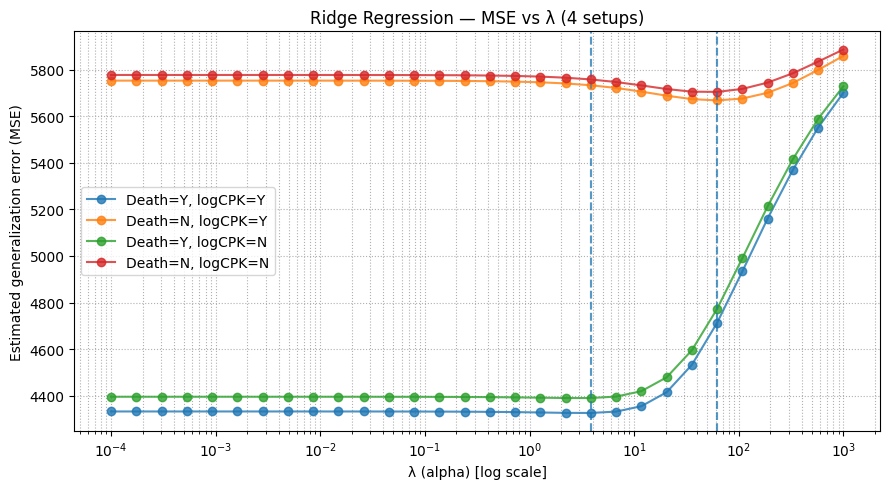


=== Predictive comparison of all Ridge setups (patient index 100) ===
         Scenario Best λ Best MSE True y Predicted ŷ Error (ŷ - y)
Death=Y, logCPK=Y   3.86  4325.88   87.0       142.4         +55.4
Death=N, logCPK=Y   62.1  5667.78   87.0       115.6         +28.6
Death=Y, logCPK=N   3.86  4389.98   87.0       161.0         +74.0
Death=N, logCPK=N   62.1  5704.40   87.0       129.2         +42.2

Top coefficients for Death=Y, logCPK=Y:
            feature    coef
        DEATH_EVENT -81.708
high_blood_pressure -22.298
            anaemia -12.925
  ejection_fraction  -6.423
                sex  -5.711

Top coefficients for Death=N, logCPK=Y:
            feature    coef
high_blood_pressure -15.255
                age -12.178
            anaemia  -9.633
   serum_creatinine  -7.004
       serum_sodium   4.007

Top coefficients for Death=Y, logCPK=N:
            feature    coef
        DEATH_EVENT -80.497
high_blood_pressure -23.259
            anaemia -15.761
  ejection_fraction  -6

In [23]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# === Base experiment ===
def run_ridge_experiment(include_death=True, log_cpk=True, example_idx=100):
    """Train Ridge with chosen setup and return all evaluation results."""
    data = pd.read_csv("../../raw_data/heart_failure_clinical_records_dataset.csv")

    continuous_cols = [
        "age", "creatinine_phosphokinase", "ejection_fraction",
        "platelets", "serum_creatinine", "serum_sodium"
    ]
    binary_cols = ["anaemia", "diabetes", "high_blood_pressure", "sex", "smoking"]
    if include_death:
        binary_cols.append("DEATH_EVENT")

    y = data["time"]
    X = data.drop(columns=["time"])

    # Optional feature transforms
    if log_cpk:
        X["creatinine_phosphokinase"] = np.log1p(X["creatinine_phosphokinase"])
    if not include_death:
        X = X.drop(columns=["DEATH_EVENT"], errors="ignore")

    # --- Cross-validation setup ---
    K = 10
    kf = KFold(n_splits=K, shuffle=True, random_state=42)
    lambdas = np.logspace(-4, 3, 30)

    def standardize(X_train, X_test):
        mu = X_train[continuous_cols].mean()
        sigma = X_train[continuous_cols].std(ddof=0).replace(0, 1.0)
        for df in [X_train, X_test]:
            df[continuous_cols] = df[continuous_cols].astype(float)
            df.loc[:, continuous_cols] = (df[continuous_cols] - mu) / sigma
        return X_train, X_test, mu, sigma

    # --- Cross-validate ---
    gen_err_est = []
    for lam in lambdas:
        fold_errs = []
        for train_idx, test_idx in kf.split(X, y):
            X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            X_train, X_test, _, _ = standardize(X_train, X_test)
            model = Ridge(alpha=lam, random_state=42)
            model.fit(X_train, y_train)
            fold_errs.append(mean_squared_error(y_test, model.predict(X_test)))
        gen_err_est.append(np.mean(fold_errs))

    # --- Identify best λ ---
    idx_best = np.argmin(gen_err_est)
    best_lambda = lambdas[idx_best]
    best_mse = gen_err_est[idx_best]

    # --- Fit final model on all data ---
    X_std = X.copy()
    X_std[continuous_cols] = X_std[continuous_cols].astype(float)
    mu_full = X_std[continuous_cols].mean()
    sigma_full = X_std[continuous_cols].std(ddof=0).replace(0, 1.0)
    X_std.loc[:, continuous_cols] = (X_std[continuous_cols] - mu_full) / sigma_full

    model = Ridge(alpha=best_lambda, random_state=42)
    model.fit(X_std, y)

    # --- Predict for chosen patient ---
    example_raw = X.iloc[example_idx].copy()
    true_y = y.iloc[example_idx]
    if log_cpk:
        example_raw["creatinine_phosphokinase"] = np.log1p(example_raw["creatinine_phosphokinase"])
    x_df = pd.DataFrame([example_raw], columns=X_std.columns)
    x_df[continuous_cols] = x_df[continuous_cols].astype(float)
    x_df.loc[:, continuous_cols] = (x_df[continuous_cols] - mu_full) / sigma_full
    y_pred = float(model.predict(x_df)[0])

    # --- Store results ---
    return {
        "include_death": include_death,
        "log_cpk": log_cpk,
        "lambdas": lambdas,
        "mse_curve": gen_err_est,
        "best_lambda": best_lambda,
        "best_mse": best_mse,
        "y_true": true_y,
        "y_pred": y_pred,
        "pred_error": y_pred - true_y,
        "model": model,
        "columns": X_std.columns,
    }


# === Run all 4 scenarios ===
scenarios = [
    {"include_death": True, "log_cpk": True},
    {"include_death": False, "log_cpk": True},
    {"include_death": True, "log_cpk": False},
    {"include_death": False, "log_cpk": False},
]
results = [run_ridge_experiment(**cfg, example_idx=100) for cfg in scenarios]

# === Plot all MSE curves ===
plt.figure(figsize=(9,5))
for r in results:
    label = f"Death={'Y' if r['include_death'] else 'N'}, logCPK={'Y' if r['log_cpk'] else 'N'}"
    plt.semilogx(r["lambdas"], r["mse_curve"], marker="o", alpha=0.8, label=label)
    plt.axvline(r["best_lambda"], linestyle="--", alpha=0.5)
plt.xlabel("λ (alpha) [log scale]")
plt.ylabel("Estimated generalization error (MSE)")
plt.title("Ridge Regression — MSE vs λ (4 setups)")
plt.legend()
plt.grid(True, which="both", ls=":")
plt.tight_layout()
plt.show()

# === Summarize prediction results ===
summary = pd.DataFrame([
    {
        "Scenario": f"Death={'Y' if r['include_death'] else 'N'}, logCPK={'Y' if r['log_cpk'] else 'N'}",
        "Best λ": f"{r['best_lambda']:.3g}",
        "Best MSE": f"{r['best_mse']:.2f}",
        "True y": f"{r['y_true']:.1f}",
        "Predicted ŷ": f"{r['y_pred']:.1f}",
        "Error (ŷ - y)": f"{r['pred_error']:+.1f}",
    }
    for r in results
])
print("\n=== Predictive comparison of all Ridge setups (patient index 100) ===")
print(summary.to_string(index=False))

# === Show top coefficients per model ===
for r in results:
    label = f"Death={'Y' if r['include_death'] else 'N'}, logCPK={'Y' if r['log_cpk'] else 'N'}"
    coef_table = pd.DataFrame({
        "feature": r["columns"],
        "coef": r["model"].coef_,
    }).sort_values("coef", key=np.abs, ascending=False).head(5)
    print(f"\nTop coefficients for {label}:")
    print(coef_table.to_string(index=False, float_format=lambda v: f"{v:.3f}"))